# Demand forcast

In [1]:
# Datenorganisation
import pandas as pd
import numpy as np
import datetime as dt

# Ploterstellung
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

# Datenvorbereitung
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split

# Standardeinstellungen
plt.rcParams['axes.xmargin'] = 0
pd.set_option('display.precision',3)
np.set_printoptions(precision=3)

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Bidirectional, Dropout, Conv1D,Concatenate,Flatten,MaxPooling1D,GlobalMaxPooling1D)
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow import keras


#tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import keras_tuner as kt

import tensorboard
from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard

#sonst  Module 
import copy
import sys
from math import ceil
import os 
cwd = os.getcwd() 

# Eingene Module 
# temporäre Einbinden des neuen Pfades mit zu ladenden Dateien
sys.path.append("C:\\Users\\markus\\EDA2\\VL07\\internalfunctions\\")
from KNN import KNN

**Laden des Datensets**

The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

    global_active_power: The total active power consumed by the household (kilowatts).
    global_reactive_power: The total reactive power consumed by the household (kilowatts).
    voltage: Average voltage (volts).
    global_intensity: Average current intensity (amps).
    sub_metering_1: Active energy for kitchen (watt-hours of active energy).
    sub_metering_2: Active energy for laundry (watt-hours of active energy).
    sub_metering_3: Active energy for climate control systems (watt-hours of active energy).
    sub_metering_4: Active energy (Difference global_active_power and sub_metering_1-3).

In [2]:
dataset = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   sub_metering_4         float64
dtypes: float64(8)
memory usage: 142.5 MB


In [3]:
dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.267
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.567
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.767
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633


In [4]:
dataset.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
sub_metering_4           25979
dtype: int64

In [5]:
index = np.nonzero(dataset["Sub_metering_3"].isnull().values)
#dataset.iloc[index[0]]

In [6]:
# Mittelwertbildung für Datenlücken, solange Datenlücke nicht zu groß ist
dataset_trans = dataset;
for i in range(8):
    dataset_trans.iloc[:,i]=dataset_trans.iloc[:,i].fillna(value= dataset_trans.iloc[:,i].rolling(window=240,center=True,min_periods=2).mean())

In [7]:
dataset_trans.isnull().sum()

Global_active_power      23879
Global_reactive_power    23879
Voltage                  23879
Global_intensity         23879
Sub_metering_1           23879
Sub_metering_2           23879
Sub_metering_3           23879
sub_metering_4           23879
dtype: int64

In [8]:
index = np.nonzero(dataset["Sub_metering_3"].isnull().values)
#dataset_trans.iloc[index[0]]

Fehlstellen löschen

In [9]:
dataset_trans.dropna(inplace =True)

**Anwendung Ersatzwertverfahren**

In [10]:
# Onehot-Encoder
tmp=OneHotEncoder(sparse_output=False).fit_transform(dataset_trans.index.weekday.to_numpy().reshape(-1,1))
for i in range(7):
    dataset_trans.insert(loc=i,column = "wd"+str(i),value=tmp[:,i])

dataset_trans.insert(loc=0,column = "year",value=dataset_trans.index.year)
dataset_trans.insert(loc=1,column = "doy",value=dataset_trans.index.dayofyear)
dataset_trans.insert(loc=2,column = "month",value=dataset_trans.index.month)
dataset_trans.insert(loc=3,column = "hour",value=dataset_trans.index.hour)
dataset_trans.insert(loc=4,column = "vh",value=dataset_trans.index.minute//15)
#dataset_trans

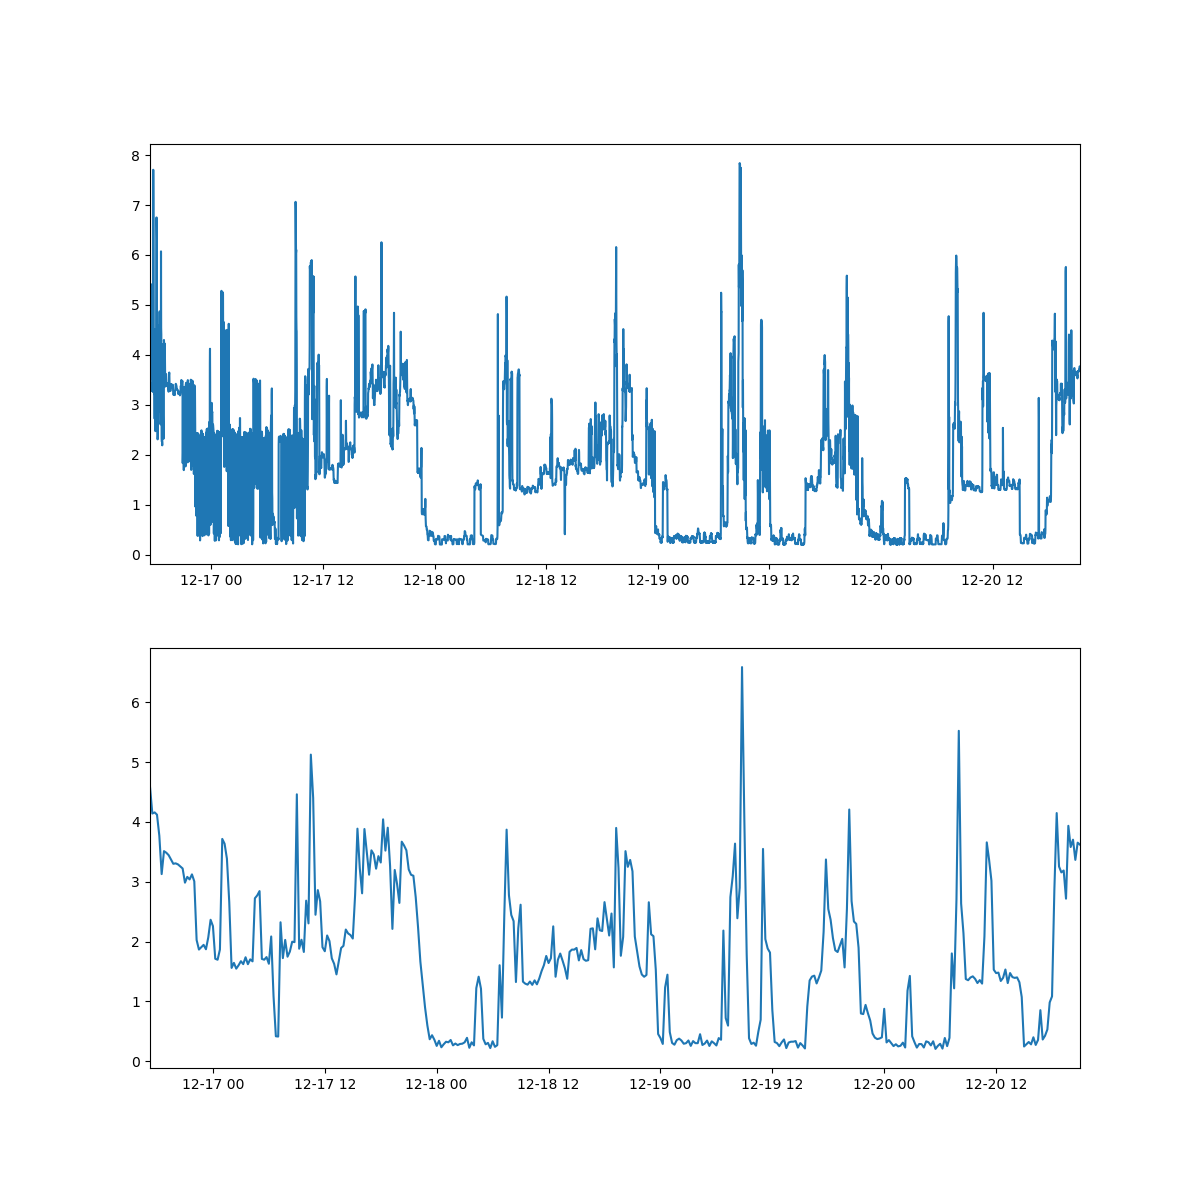

In [11]:
time =400
fig, ax =plt.subplots(nrows=2,ncols=1,**{'figsize': (12, 12)});lab=["Training","Validierung","Test"]
lin1=ax[0].plot(dataset_trans.index[:15*time],dataset_trans.iloc[:15*time,12]);
dataset_trans_15 = dataset_trans.resample("15min").mean()
lin1=ax[1].plot(dataset_trans_15.index[:time],dataset_trans_15.iloc[:400,12]);

In [12]:
# Vorgaben zur Datentrennung
sections=(.6,.25,.15)
shuffle=False

# Vorbereitete Klasse
KNN2 = KNN()
# Unterteilung der Samples
KNN2.split_sample(dataset_trans,dataset_trans["Global_active_power"].values.reshape(-1,1),shuffle=shuffle,sections =sections)
#Auswahl der Skalierungsmethode "MinMax" vs. "standard"
KNN2.scaler("MinMax")

**Datenvorbereitung**<br>
Feature-Selektion

der Parameter `inputvars_hist` nimmt die nur historisch verfügbaren Informationen auf; formulieren Sie den entsprechenden Vektor 
der Parameter `inputvars_future` nimmt die verfügbaren Informationen im Prognosezeitraum auf.

In [13]:
# frei wählbar
inputvars_hist = np.arange(dataset_trans.shape[1])
inputvars_hist_anz, =inputvars_hist.shape

# für Aufgabe 1 wird dies nicht berücksichtigt!
inputvars_future = np.arange(12)
inputvars_future_anz, =inputvars_future.shape

**LSTM Datensatz-Länge**

In einem LSTM-Modell wird jedes Sample als Matrix präsentiert [timesteps, features]
Insgesamt ist der Datensatz ein dreidimensionaler Tensor [sample, timesteps, features]

- Festlegung Prognosehorizont (horizon)
- Festlegung des historischen Samples (timesteps) 

In [14]:
#verwendete Lags der Gasdaten (erste Spalte von in.tmpX sind Gasdaten)
# betrachtete timesteps pro sample
timesteps = 90
# wieviele outputs sollen erzeugt werden
horizon   = 15
# wie soll der Output aggregiert werden 
aggr = 15

**Zuschneiden der Daten**

In [15]:
def sample_generator(x,y,timesteps,horizon,aggr,inputs_hist,inputs_future,batch_size=500,epochs=10):

#******** Schleife über Epochen *********************
#******** je Batchsize werden Daten zurückgeliefert
    batch_count=0
    xhist_,xfuture_,y_=[],[],[] 
    for epo in range(epochs):
# ************ Erstellung der Samples aus den Rohdaten*******************************
    
        # Anzahl der verkürzen sich noch um die notwendigen timesteps (nach hinten) 
        # sowie die Anzahl der Prognoseschritte (nach vorne)
        idx_range = range(len(x) - (timesteps + horizon))

        # Schleife für jedes Samples
        # Für jeden Tag liegt ein Beobachtungswert vor
        for idx in idx_range:
            # erster Beobachtungswert(e) liegt am ende der "ersten Zeitserie
            y_.append(np.squeeze(y[idx+timesteps-1:idx+timesteps+horizon-1]).reshape(aggr,-1).mean(axis=0))
            xfuture_.append(np.squeeze(x[idx+timesteps-1:idx+timesteps+horizon-1,inputs_future]).reshape(aggr,-1).mean(axis=0))
            # zurodnung der Zeitserie [timesteps x features]
            xhist_.append(x[idx:idx+timesteps,inputs_hist])
            batch_count+=1
            if (batch_count==batch_size or idx ==idx_range[-1]):
                # Rückgabe des Batch
                # für Aufgabe 1
                yield np.array(xhist_),np.array(y_) 
                # für Aufgabe >1 
                #yield (np.array(xhist_),np.array(xfuture_)),np.array(y_) 
                xhist_=[]
                xfuture_=[]
                y_=[]
                batch_count=0

In [16]:
test_gen=sample_generator(KNN2.x_norm[0],KNN2.y_norm[0],timesteps,horizon,aggr,inputvars_hist,inputvars_future)
x_,y_=next(test_gen)
print(x_[0].shape,x_[1].shape,y_.shape)

(90, 20) (90, 20) (500, 1)


## CNN-/LSTM-Encoder-Decoder

```python
Conv1D(
    filters,
    kernel_size,
    strides=1,
    padding='valid',
    data_format='channels_last',
    dilation_rate=1,
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

```

- Input:  (sequence_length, features)
- Output: (new_sequence_length, filters)

WICHTIG!!!:<br>

- Die Convolution-Operation wird nur über die Zeitdimension `sequence_length` durchgeführt und nicht über `features`. Für jedes `feature` wird ein eigener `Kanal` verwendet!
- Die Anzahl der Filter (`filters`) der Conv1D-Schicht gibt an, wie viele Kanäle im **Ausgangstensor** vorhanden sein werden. 
- Jeder Kanal im Ausgangstensor wird aus der **gewichteten Summe** der Werte **aller Kanäle im Eingabetensor** berechnet, wobei die Gewichte durch die Filterkoeffizienten bestimmt werden.
- Wenn eine Conv1D-Schicht auf eine Eingabe mit input_dim Kanälen angewendet wird und filters Filtern in der Schicht spezifiziert werden, werden insgesamt features * filters Filterkoeffizienten trainiert. Die Anzahl der Kanäle im Ausgangstensor (filters) ist jedoch unabhängig von der Anzahl der Kanäle in der Eingabe (features) und hängt nur von der Anzahl der Filter ab, die in der Schicht spezifiziert wurden.

Pooling Layer:<br>
- MaxPooling1D 
- layerGlobalMaxPooling1D layer

Beide Layer gehören zur Kategorie der Pooling-Layer in einem neuronalen Netzwerk und dienen dazu, die Dimensionalität von Daten in einem CNN zu reduzieren.

Der Hauptunterschied zwischen `MaxPooling1D` und `GlobalMaxPooling1D` besteht darin, dass MaxPooling1D eine feste Größe für die Pooling-Operation hat, während GlobalMaxPooling1D die gesamte Eingabesequenz in Betracht zieht.
Bei MaxPooling1D wird die Eingabe in kleine Fenster aufgeteilt, und der höchste Wert in jedem Fenster wird beibehalten. Diese Fenster werden dann um einen bestimmten Schritt verschoben, bis alle möglichen Fenster abgedeckt sind. Dadurch wird die Größe der Daten reduziert und es wird eine gewisse Invarianz gegenüber kleinen Verschiebungen in den Daten erreicht.
Bei GlobalMaxPooling1D wird dagegen der höchste Wert aus der gesamten Eingabesequenz ausgewählt. Dadurch wird die gesamte Sequenz auf einen einzelnen Wert reduziert, was in manchen Anwendungen von Vorteil sein kann, wenn man nur eine globale Zusammenfassung der Daten benötigt.


**Aufgabe1:** reines CNN-Netzwerk<br>
Setzen Sie ein Conv1D-Netz um. Unterteilen Sie bei diesem Netz nicht zwischen historischen und  Analysieren Sie folgende Fragen:

- Einfluss durch Variation des Parameters timesteps
- Einfluss der Netztiefe und Netzagregation (ins. durch Kernelsize und Stride beeinflussbar)
- Einfluss der Hinzunahme von MaxPooling1D- Layern

Umsetzung: WICHTIG hier muss die entsprechende Yield Anweisung des Generators gesetzt sein (siehe Methode "sample_generator") 

**Aufgabe2:** reines CNN-Netzwerk II <br>
Erweitern Sie das Conv1D-Netz aus Aufgabe 1 um eine weitere Inputschicht mit Informationen zum Typtag etc. innerhalb des Prognosezeitraums (functional api notwendig).<br>
Umsetzung: WICHTIG hier muss die entsprechende Yield Anweisung des Generators geändert werden (siehe Methode "sample_generator") 
<img src ='Aufg2.png'>

**Aufgabe3:** CNN-LSTM-Netzwerk <br>
Erweitern Sie das Netzwerk aus Aufgabe zwei indem Sie noch LSTM-Layer hinter die Conv1D-Layer setzen

**Aufgabe4:** CNN-LSTM-Netzwerk <br>
Nutzen Sie für jede Schicht den TimeDistributed-Layer als "Wrapper". Informieren Sie sich vorab über die Wirkungsweise.

**Aufgabe5:** CNN-LSTM-Netzwerk <br>
Setzen Sie das Netzwerk aus dem Paper um. Für die Umsetzung dieser Aufgabe erhalten Sie einen Bonus auf die Abgabe.  

**Netzwerk Aufg. 1**

In [17]:
model_name = 'Aufg1'  
inputs=Input #Hier fehlt noch der Input
convN=Conv1D(fiters=64,kernel_size=12,strides=1,padding="valid", activation="relu")(inputs)
ConvN=Conv1D(fiters=64,kernel_size=6,strides=1,padding="valid", activation="relu")(ConvN)
ConvN=Conv1D(fiters=64,kernel_size=1,strides=1,padding="valid", activation="relu")(ConvN)
Flatten=Flatten()(ConvN)
Dropout=Dropout(0.5)(Flatten)
Dense=Dense()(Dropout)#hier fehlen parameter
outputs=Outputs()()#hier fehlen parameter

model = Model(inputs, outputs)


**Netzwerk Aufg. 2**

**Netzwerk Aufg. 3**

**Netzwerk Aufg. 4**

**Netzwerk Aufg. 5**

## Training

In [23]:
# Ordner für Ablage
checkpoint_filepath = cwd + '\logs\ ' + model_name


# Eigenschaften des Optimierer
epochs=40
batch_size =1028

# Generator initialisieren
gen_train = sample_generator(KNN2.x_norm[0],KNN2.y_norm[0],timesteps,horizon,aggr,inputvars_hist,inputvars_future,batch_size,epochs)
gen_val =   sample_generator(KNN2.x_norm[1],KNN2.y_norm[1],timesteps,horizon,aggr,inputvars_hist,inputvars_future,batch_size,epochs)

steps_train = ceil((len(KNN2.x_norm[0]) - (timesteps + horizon))/batch_size)
steps_val =   ceil((len(KNN2.x_norm[1]) - (timesteps + horizon))/batch_size)

# Einstellungen des Optimierers
KNN2.optimizer = optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=KNN2.optimizer, metrics=['mae'])

# Callbacks
KNN2.early = EarlyStopping(monitor='val_loss', patience=4)
KNN2.check = ModelCheckpoint(filepath=checkpoint_filepath+'/'+model_name+'.h5', monitor='val_loss', save_best_only=True)

KNN2.tensorboard = tf.keras.callbacks.TensorBoard(log_dir = checkpoint_filepath,histogram_freq=1)

#Durchführung
KNN2.history = model.fit(gen_train, epochs=epochs, steps_per_epoch=steps_train, \
                              validation_data=gen_val, validation_steps=steps_val, \
                              callbacks=[KNN2.early, KNN2.check, KNN2.tensorboard])

Epoch 1/40
1198/1198 [==============================] - 72s 58ms/step - loss: 0.0020 - mae: 0.0410 - val_loss: 0.0016 - val_mae: 0.0358
Epoch 2/40
1198/1198 [==============================] - 68s 57ms/step - loss: 0.0012 - mae: 0.0305 - val_loss: 0.0014 - val_mae: 0.0338
Epoch 3/40
1198/1198 [==============================] - 69s 58ms/step - loss: 0.0011 - mae: 0.0285 - val_loss: 0.0013 - val_mae: 0.0334
Epoch 4/40
1198/1198 [==============================] - 72s 60ms/step - loss: 0.0010 - mae: 0.0278 - val_loss: 0.0013 - val_mae: 0.0333
Epoch 5/40
1198/1198 [==============================] - 71s 59ms/step - loss: 9.6205e-04 - mae: 0.0265 - val_loss: 0.0012 - val_mae: 0.0314
Epoch 6/40
1198/1198 [==============================] - 71s 59ms/step - loss: 9.4473e-04 - mae: 0.0263 - val_loss: 0.0012 - val_mae: 0.0319
Epoch 7/40
1198/1198 [==============================] - 67s 56ms/step - loss: 9.2920e-04 - mae: 0.0260 - val_loss: 0.0013 - val_mae: 0.0329
Epoch 8/40
1198/1198 [==============

**Überwachung des Trainings**

In [ ]:
# ab der xten epoche
epoch_shown = 1
fig, ax =plt.subplots(nrows=1,ncols=1,**{'figsize': (12, 5)})
lin3 = ax.plot(KNN2.history.history['val_loss'][epoch_shown:],label='KNN2val_loss')
lin4 = ax.plot(KNN2.history.history['loss'][epoch_shown:],label='KNN2loss')
ax.set(xlabel='Epoche',ylabel='loss')
ax.legend();
ax.grid(visible=True)

### Auswerten der Netze

In [ ]:
from tensorflow.keras.models import load_model
KNN2.model = load_model(checkpoint_filepath+'/'+model_name+'.h5')

In [ ]:
gen=[];KNN2.x_in=[];KNN2.y_in=[]
for i in range(3):
    gen.append(sample_generator(KNN2.x_norm[i],KNN2.y_norm[i],timesteps,horizon,aggr,inputvars_hist,inputvars_future,5000,1))
    tmp=next(gen[i])
    KNN2.x_in.append(tmp[0]);
    KNN2.y_in.append(tmp[1]);
KNN2.loss =np.zeros((3,2))    
for i in range(3):
    KNN2.loss[i,:]=KNN2.model.evaluate(KNN2.x_in[i],KNN2.y_in[i])

vergleich = pd.DataFrame(data = KNN2.loss,index=["MAETrain","MAEVal","MAETest"],columns=["KNN2 Loss","KNN2 MAE"])

# Rücktransformierung des Fehlers
if KNN2.scaler=='MinMax':
    vergleich.iloc[:,:] =np.round(KNN2.scalerY.inverse_transform(vergleich)-KNN2.scalerY.min_,0)
else:
    vergleich.iloc[:,:]  =np.round(KNN2.scalerY.inverse_transform(vergleich)-KNN2.scalerY.mean_,0)
vergleich

In [ ]:
KNN2.x_in[i][1].shape

**Erstellung von Prognosen**

In [ ]:
ypred_norm=[];[ypred_norm.append(np.squeeze(KNN2.model.predict(KNN2.x_in[i]))) for i in range(3)]
#**Inverse Scalierung**
ypred=[];[ypred.append(KNN2.scalerY.inverse_transform(ypred_norm[i].reshape(1,-1))) for i in range(3)];
yorg=[];[yorg.append(KNN2.scalerY.inverse_transform(KNN2.y_in[i][:,0].reshape(1,-1))) for i in range(3)];

**Darstellung im Zeitablauf**

In [ ]:
# Verlauf Day-Ahead-Prognose
fig, ax =plt.subplots(nrows=3,ncols=1,**{'figsize': (12, 12)});lab=["Training","Validierung","Test"]
#KNN2.x[i].index[timesteps+1:-horizon+1],
for i in range(3):
    lin1=ax[i].plot(yorg[i].T,label='orginal',linestyle=None);
    lin3=ax[i].plot(ypred[i].T,label='KNN2pred',linestyle=None);
    ax[i].set(ylabel="data [€/MW]",xlabel="Zeit[d]",title=lab[i]);
    ax[i].legend()